In [1]:
import pyximport
pyximport.install()

from conv_layer import ConvolutionalLayer
from dense import Dense
from max_pool_layer import MaxPool
from relu_activation import Relu
from softmax_activation import Softmax
from flatten import Flatten
from batchnorm import BatchNormalization
from dropout import Dropout
from model import Model
from data_utils import *
import numpy as np

np.random.seed(5)
data = get_CIFAR10_data(draw=False)


    

('Training data shape: ', (50000, 32, 32, 3))
('Training labels shape: ', (50000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))
Before Augmentation
('Training data shape: ', (50000, 32, 32, 3))
('Training labels shape: ', (50000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [2]:
model = Model(data['X_train'],data['y_train'],data['X_test'],data['y_test'],num_epochs=50,batch_size = 250)


model.add_augmentation(  rotation_range=5,
                         height_shift_range=0.16,
                         width_shift_range=0.16,
                         img_row_axis=1,
                         img_col_axis=2,
                         img_channel_axis=0,
                         horizontal_flip=True,
                         vertical_flip=False)

#model.add_layer(BatchNormalization())



model.add_layer(ConvolutionalLayer(num_filters=32))
model.add_layer(Relu())
model.add_layer(Dropout(prob=0.8))
model.add_layer(ConvolutionalLayer(input_shape=[32,32,32],num_filters=32,filter_dims=[32,3,3]))
model.add_layer(Relu())
model.add_layer(MaxPool())


model.add_layer(ConvolutionalLayer(input_shape=[32,16,16],num_filters=64,filter_dims=[32,3,3]))
model.add_layer(Relu())
model.add_layer(Dropout(prob=0.75))
model.add_layer(ConvolutionalLayer(input_shape=[64,16,16],num_filters=64,filter_dims=[64,3,3]))
model.add_layer(Relu())
model.add_layer(MaxPool())



(32, 32, 32)
(32, 32, 32)
(64, 16, 16)
(64, 16, 16)


In [3]:
model.add_layer(Flatten())

model.add_layer(Dropout(prob=0.85))

model.add_layer(Dense(input_shape=4096,neurons=1024))
model.add_layer(Relu())
model.add_layer(Dropout(prob=0.80))



model.add_layer(Dense(input_shape=1024,neurons=512))
model.add_layer(Relu())
model.add_layer(Dropout(prob=0.80))


model.add_layer(Dense(input_shape=512,neurons=10))
model.add_layer(Softmax())




In [4]:
print (model.layers)


[<conv_layer.ConvolutionalLayer instance at 0x7fb5bcb275f0>
 <relu_activation.Relu instance at 0x7fb5bcb27560>
 <dropout.Dropout instance at 0x7fb5bcb27758>
 <conv_layer.ConvolutionalLayer instance at 0x7fb5bcb277a0>
 <relu_activation.Relu instance at 0x7fb5bcb277e8>
 <max_pool_layer.MaxPool instance at 0x7fb5bcb27908>
 <conv_layer.ConvolutionalLayer instance at 0x7fb5bcb27950>
 <relu_activation.Relu instance at 0x7fb5bcb27998>
 <dropout.Dropout instance at 0x7fb5bcb27a70>
 <conv_layer.ConvolutionalLayer instance at 0x7fb5bcb27ab8>
 <relu_activation.Relu instance at 0x7fb5bcb27b00>
 <max_pool_layer.MaxPool instance at 0x7fb5bcb27bd8>
 <flatten.Flatten instance at 0x7fb5bcb27cb0>
 <dropout.Dropout instance at 0x7fb5cb8472d8>
 <dense.Dense instance at 0x7fb5bcb27cf8>
 <relu_activation.Relu instance at 0x7fb5bcb27d88>
 <dropout.Dropout instance at 0x7fb5bcb27e60>
 <dense.Dense instance at 0x7fb5bcb27dd0>
 <relu_activation.Relu instance at 0x7fb5bcb27ef0>
 <dropout.Dropout instance at 0x7f

In [5]:
model.train()

('Accuracy increased from ', '0', '  to ', '0.1')------------] 0.0% ...Loss: 2.30258509394
('Epoch: ', 0)
('Training Accuracy: ', 0.092999999999999999)
('Validation Accuracy: ', 0.10000000000000001)
('Accuracy increased from ', '0.1', '  to ', '0.3587')=======] 99.5% ...Loss: 1.98752282673
('Epoch: ', 1)
('Training Accuracy: ', 0.32200000000000001)
('Validation Accuracy: ', 0.35870000000000002)
('Accuracy increased from ', '0.3587', '  to ', '0.4494')====] 99.5% ...Loss: 1.69468508791
('Epoch: ', 2)
('Training Accuracy: ', 0.42799999999999999)
('Validation Accuracy: ', 0.44940000000000002)
('Accuracy increased from ', '0.4494', '  to ', '0.5294')====] 99.5% ...Loss: 1.46990750453
('Epoch: ', 3)
('Training Accuracy: ', 0.53800000000000003)
('Validation Accuracy: ', 0.52939999999999998)
('Accuracy increased from ', '0.5294', '  to ', '0.5895')====] 99.5% ...Loss: 1.29415211981
('Epoch: ', 4)
('Training Accuracy: ', 0.61099999999999999)
('Validation Accuracy: ', 0.58950000000000002)
('Acc

In [6]:
model.load_best()
test_acc = model.check_accuracy(data['X_test'],data['y_test'])
print (test_acc)


0.8258


In [7]:
def predict(model, X, num_samples=None, batch_size=100):
         # Maybe subsample the data
        N = X.shape[0]
        num_layers = model.layers.shape[0] 
        
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]
        
        # Compute predictions in batches
        num_batches = int(N / batch_size)
        if N % batch_size != 0:
          num_batches += 1
        y_pred = []
        for i in range(num_batches):
            
            start = i * batch_size
            end = (i + 1) * batch_size
          
            output = None
            for j in range(num_layers - 1):
                if j == 0:
                    output = model.layers[j].forward(X[start:end],mode="testing")
                else:
                    output = model.layers[j].forward(output,mode="testing")
        
            y_pred.append(np.argmax(output, axis=1))
        y_pred = np.hstack(y_pred)
        #acc = np.mean(y_pred == y)
        
        return y_pred

In [8]:
X_test = data['X_test']
y_test = data['y_test']
y_test_pred = predict(model,X_test)

#test_acc = np.mean(y_test_pred == y_test)
#print ("Average Test Accuracy: " + str(test_acc))


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

answers_comparison = (y_test_pred == y_test)
print ("Average Accuracy: " + str(np.mean(answers_comparison)))
print ("Accuracy per Class: ")
class_accuracy = []
for i in range(10):
    idx = np.flatnonzero(y_test == i)
    current_correct = np.sum(answers_comparison[idx])
    current_accuracy = current_correct/1000.0
    class_accuracy.append(current_accuracy)
    print ("Class: "+ str(i)+ " ("+classes[i]+")" + ", accuracy: " + str(current_accuracy))


Average Accuracy: 0.8258
Accuracy per Class: 
Class: 0 (plane), accuracy: 0.89
Class: 1 (car), accuracy: 0.909
Class: 2 (bird), accuracy: 0.69
Class: 3 (cat), accuracy: 0.67
Class: 4 (deer), accuracy: 0.817
Class: 5 (dog), accuracy: 0.689
Class: 6 (frog), accuracy: 0.924
Class: 7 (horse), accuracy: 0.853
Class: 8 (ship), accuracy: 0.889
Class: 9 (truck), accuracy: 0.927


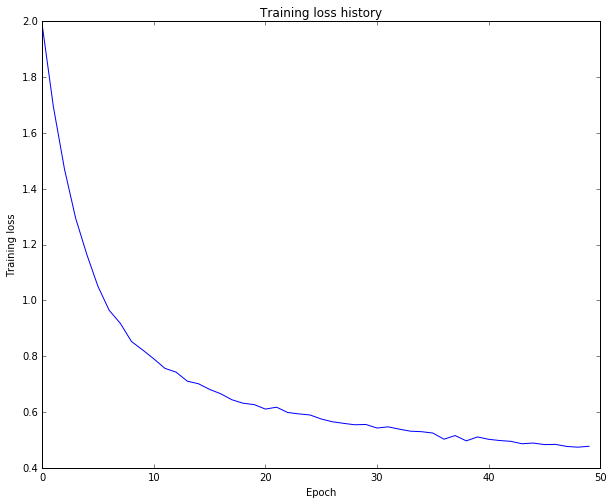

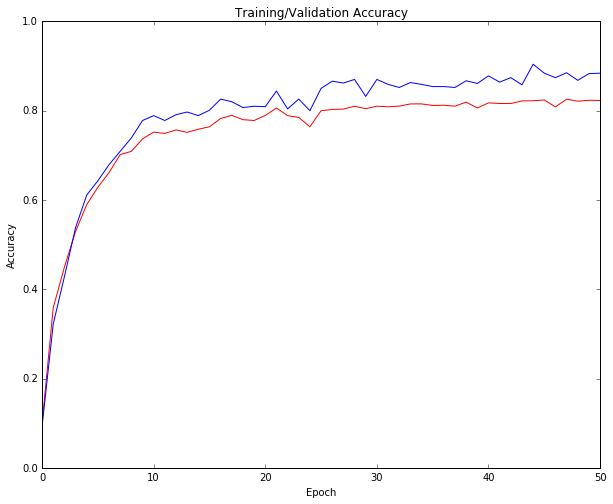

In [9]:
plt.plot(model.actual_training_loss, '-')
plt.title('Training loss history')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.show()


plt.plot(model.val_acc_history, 'r-')
plt.plot(model.train_acc_history, 'b-')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [10]:
prev_loss = model.actual_training_loss
prev_val_acc = model.val_acc_history
prev_train_acc = model.train_acc_history

In [12]:
import pickle
with open("./saved/own_model_8258.file", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [13]:
model.num_epochs = 20

In [14]:
model.train()

('Accuracy increased from ', '0.8258', '  to ', '0.8297')----] 0.0% ...Loss: 0.430052127835
('Epoch: ', 0)
('Training Accuracy: ', 0.88600000000000001)
('Validation Accuracy: ', 0.82969999999999999)
('Accuracy increased from ', '0.8297', '  to ', '0.8314')====] 99.5% ...Loss: 0.476189455936
('Epoch: ', 1)
('Training Accuracy: ', 0.88400000000000001)
('Validation Accuracy: ', 0.83140000000000003)
('Epoch: ', 2)===============================================] 99.5% ...Loss: 0.475333998781
('Training Accuracy: ', 0.879)
('Validation Accuracy: ', 0.82499999999999996)
('Epoch: ', 3)===============================================] 99.5% ...Loss: 0.468636846033
('Training Accuracy: ', 0.90200000000000002)
('Validation Accuracy: ', 0.82320000000000004)
('Epoch: ', 4)===============================================] 99.5% ...Loss: 0.465321977521
('Training Accuracy: ', 0.89000000000000001)
('Validation Accuracy: ', 0.82479999999999998)
('Epoch: ', 5)==============================================

In [15]:
model.load_best()
X_test = data['X_test']
y_test = data['y_test']
y_test_pred = predict(model,X_test)

#test_acc = np.mean(y_test_pred == y_test)
#print ("Average Test Accuracy: " + str(test_acc))


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

answers_comparison = (y_test_pred == y_test)
print ("Average Accuracy: " + str(np.mean(answers_comparison)))
print ("Accuracy per Class: ")
class_accuracy = []
for i in range(10):
    idx = np.flatnonzero(y_test == i)
    current_correct = np.sum(answers_comparison[idx])
    current_accuracy = current_correct/1000.0
    class_accuracy.append(current_accuracy)
    print ("Class: "+ str(i)+ " ("+classes[i]+")" + ", accuracy: " + str(current_accuracy))


Average Accuracy: 0.8375
Accuracy per Class: 
Class: 0 (plane), accuracy: 0.879
Class: 1 (car), accuracy: 0.937
Class: 2 (bird), accuracy: 0.779
Class: 3 (cat), accuracy: 0.611
Class: 4 (deer), accuracy: 0.846
Class: 5 (dog), accuracy: 0.698
Class: 6 (frog), accuracy: 0.936
Class: 7 (horse), accuracy: 0.855
Class: 8 (ship), accuracy: 0.898
Class: 9 (truck), accuracy: 0.936


In [17]:
#new_loss = np.concatenate(prev_loss,model.actual_training_loss)
#new_train_acc = np.concatenate(prev_train_acc,model.train_acc_history)
#new_val_acc = np.concatenate(prev_val_acc,model.val_acc_history)


new_loss = prev_loss + model.actual_training_loss
new_train_acc = prev_train_acc + model.train_acc_history
new_val_acc = prev_val_acc + model.val_acc_history


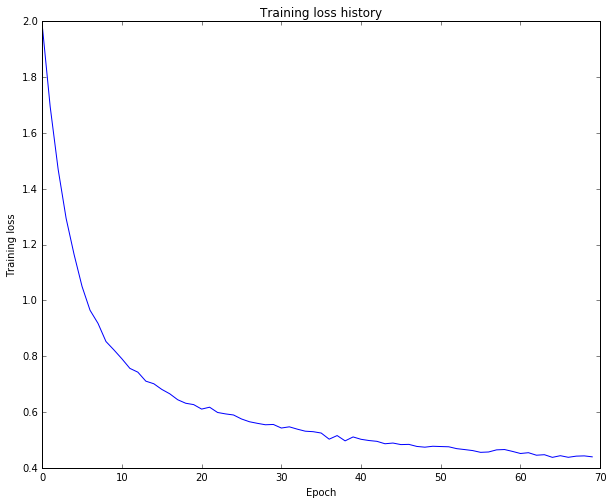

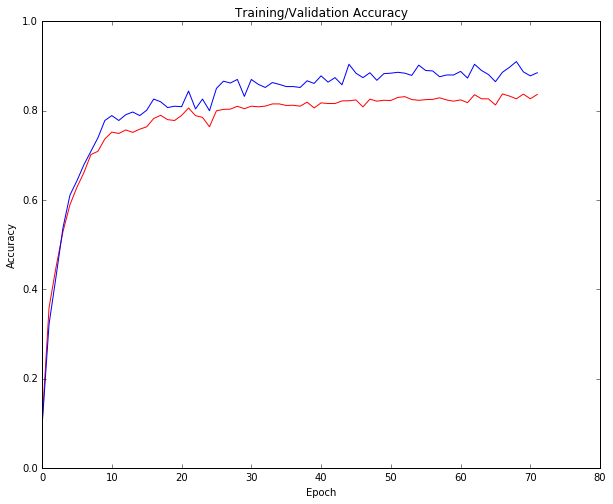

In [18]:
plt.plot(new_loss, '-')
plt.title('Training loss history')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.show()


plt.plot(new_val_acc, 'r-')
plt.plot(new_train_acc, 'b-')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [19]:
prev_loss = model.actual_training_loss
prev_val_acc = model.val_acc_history
prev_train_acc = model.train_acc_history

In [20]:
model.train()

('Epoch: ', 0)-----------------------------------------------] 0.0% ...Loss: 0.434650905104
('Training Accuracy: ', 0.88200000000000001)
('Validation Accuracy: ', 0.83720000000000006)
('Epoch: ', 1)===============================================] 99.5% ...Loss: 0.449537889739
('Training Accuracy: ', 0.88800000000000001)
('Validation Accuracy: ', 0.82310000000000005)
('Epoch: ', 2)===============================================] 99.5% ...Loss: 0.440353674285
('Training Accuracy: ', 0.88800000000000001)
('Validation Accuracy: ', 0.82250000000000001)
('Epoch: ', 3)===============================================] 99.5% ...Loss: 0.438905399477
('Training Accuracy: ', 0.874)
('Validation Accuracy: ', 0.83109999999999995)
('Epoch: ', 4)===============================================] 99.5% ...Loss: 0.432096365824
('Training Accuracy: ', 0.875)
('Validation Accuracy: ', 0.83250000000000002)
('Epoch: ', 5)===============================================] 99.5% ...Loss: 0.441840680234
('Training 

In [21]:
model.load_best()
X_test = data['X_test']
y_test = data['y_test']
y_test_pred = predict(model,X_test)

#test_acc = np.mean(y_test_pred == y_test)
#print ("Average Test Accuracy: " + str(test_acc))


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

answers_comparison = (y_test_pred == y_test)
print ("Average Accuracy: " + str(np.mean(answers_comparison)))
print ("Accuracy per Class: ")
class_accuracy = []
for i in range(10):
    idx = np.flatnonzero(y_test == i)
    current_correct = np.sum(answers_comparison[idx])
    current_accuracy = current_correct/1000.0
    class_accuracy.append(current_accuracy)
    print ("Class: "+ str(i)+ " ("+classes[i]+")" + ", accuracy: " + str(current_accuracy))

Average Accuracy: 0.8399
Accuracy per Class: 
Class: 0 (plane), accuracy: 0.865
Class: 1 (car), accuracy: 0.916
Class: 2 (bird), accuracy: 0.747
Class: 3 (cat), accuracy: 0.646
Class: 4 (deer), accuracy: 0.833
Class: 5 (dog), accuracy: 0.724
Class: 6 (frog), accuracy: 0.945
Class: 7 (horse), accuracy: 0.899
Class: 8 (ship), accuracy: 0.875
Class: 9 (truck), accuracy: 0.949


In [22]:
new_loss = prev_loss + model.actual_training_loss
new_train_acc = prev_train_acc + model.train_acc_history
new_val_acc = prev_val_acc + model.val_acc_history

In [25]:
model.load_best()
model.add_augmentation(  rotation_range=5,
                         height_shift_range=0.19,
                         width_shift_range=0.21,
                         img_row_axis=1,
                         img_col_axis=2,
                         img_channel_axis=0,
                         horizontal_flip=True,
                         vertical_flip=False)

In [26]:
model.train()

('Accuracy increased from ', '0.8399', '  to ', '0.8412')----] 0.0% ...Loss: 0.416649906355
('Epoch: ', 0)
('Training Accuracy: ', 0.88100000000000001)
('Validation Accuracy: ', 0.84119999999999995)
('Epoch: ', 1)===============================================] 99.5% ...Loss: 0.467394733273
('Training Accuracy: ', 0.89200000000000002)
('Validation Accuracy: ', 0.8337)
('Epoch: ', 2)===============================================] 99.5% ...Loss: 0.460100148187
('Training Accuracy: ', 0.89500000000000002)
('Validation Accuracy: ', 0.84009999999999996)
('Epoch: ', 3)===============================================] 99.5% ...Loss: 0.459648421999
('Training Accuracy: ', 0.90500000000000003)
('Validation Accuracy: ', 0.82989999999999997)
('Epoch: ', 4)===============================================] 99.5% ...Loss: 0.453941521688
('Training Accuracy: ', 0.89000000000000001)
('Validation Accuracy: ', 0.83630000000000004)


KeyboardInterrupt: 

In [29]:
model.load_best()
model.add_augmentation(  rotation_range=5,
                         height_shift_range=0.19,
                         width_shift_range=0.21,
                         img_row_axis=1,
                         img_col_axis=2,
                         img_channel_axis=0,
                         horizontal_flip=True,
                         vertical_flip=False)

In [30]:
model.train()

('Epoch: ', 0)-----------------------------------------------] 0.0% ...Loss: 0.516258341744
('Training Accuracy: ', 0.90300000000000002)
('Validation Accuracy: ', 0.84119999999999995)
('Epoch: ', 1)===============================================] 99.5% ...Loss: 0.462959887639
('Training Accuracy: ', 0.89400000000000002)
('Validation Accuracy: ', 0.83130000000000004)
('Epoch: ', 2)===============================================] 99.5% ...Loss: 0.462918830924
('Training Accuracy: ', 0.89200000000000002)
('Validation Accuracy: ', 0.83919999999999995)
('Epoch: ', 3)===============================================] 99.5% ...Loss: 0.458645596478
('Training Accuracy: ', 0.88900000000000001)
('Validation Accuracy: ', 0.83009999999999995)
('Epoch: ', 4)===============================================] 99.5% ...Loss: 0.454220571116
('Training Accuracy: ', 0.89200000000000002)
('Validation Accuracy: ', 0.82579999999999998)


KeyboardInterrupt: 

In [31]:
model.load_best()
X_test = data['X_test']
y_test = data['y_test']
y_test_pred = predict(model,X_test)

#test_acc = np.mean(y_test_pred == y_test)
#print ("Average Test Accuracy: " + str(test_acc))


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

answers_comparison = (y_test_pred == y_test)
print ("Average Accuracy: " + str(np.mean(answers_comparison)))
print ("Accuracy per Class: ")
class_accuracy = []
for i in range(10):
    idx = np.flatnonzero(y_test == i)
    current_correct = np.sum(answers_comparison[idx])
    current_accuracy = current_correct/1000.0
    class_accuracy.append(current_accuracy)
    print ("Class: "+ str(i)+ " ("+classes[i]+")" + ", accuracy: " + str(current_accuracy))

Average Accuracy: 0.8412
Accuracy per Class: 
Class: 0 (plane), accuracy: 0.872
Class: 1 (car), accuracy: 0.92
Class: 2 (bird), accuracy: 0.746
Class: 3 (cat), accuracy: 0.64
Class: 4 (deer), accuracy: 0.839
Class: 5 (dog), accuracy: 0.735
Class: 6 (frog), accuracy: 0.931
Class: 7 (horse), accuracy: 0.898
Class: 8 (ship), accuracy: 0.887
Class: 9 (truck), accuracy: 0.944
